In [37]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot, skew
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set()

### Loading data

In [13]:
train_path = os.path.join('datasets', 'housing_prices', 'train.csv')
train_df = pd.read_csv(train_path)

test_path = os.path.join('datasets', 'housing_prices', 'test.csv')
test_df = pd.read_csv(test_path)

print(f'Train shape {train_df.shape}')
print(f'Test shape {test_df.shape}')
train_df.head()

Train shape (1460, 81)
Test shape (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Train set and test set are almost equal. Totally there are only 2919 (1460 + 1459) observations - it is means dataset is really small. However there are a lot of features. It is difficult to describe every one of them (detailed description can be find in localization datasets/housing_prices/data_description.txt. 

### Label

The purpose of this notebook is to train a model for estimating SalePrice (one of columns in train set). It is called regression because we get features describing a house and we need to predict its sale price when sale price is a continous feature. SalePrice is our label and it is always good to see the distribution of the label and whether there are any outliers

<AxesSubplot:ylabel='SalePrice'>

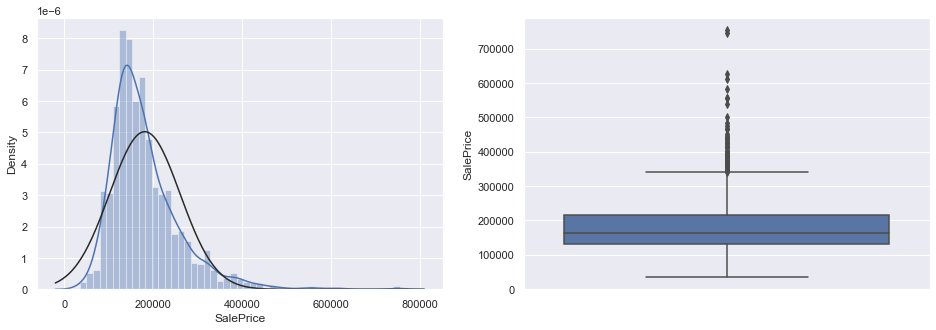

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(train_df['SalePrice'], ax=axes[0], fit=norm)
sns.boxplot(y=train_df['SalePrice'], ax=axes[1])

### Skewed label and outliers

The histogram shows that SalePrice is positively skewed. It means that most values are clustered around the left tail of the distribution while the right tail of the distribution is longer. Most machine learning algorithms prefer normally distributed labels so I will take logarith of SalePrice (actually log(SalePrice +1)).

Additionally there are a few outliers. I think it is safe to remove all rows where SalePrice is higher than 500 000.

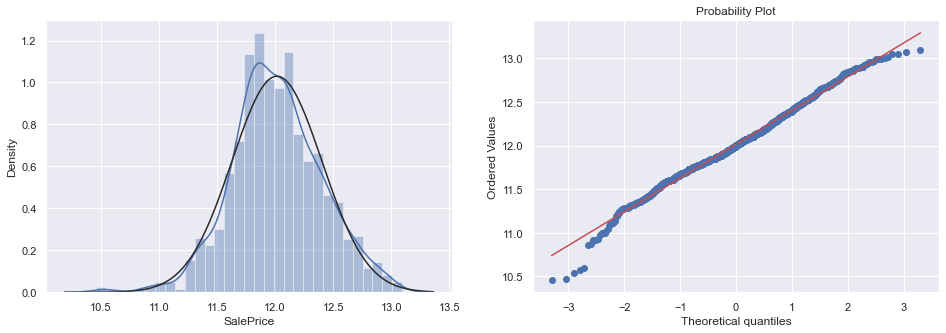

In [15]:
train_df = train_df.loc[train_df['SalePrice'] <= 500_000]
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
_, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(train_df['SalePrice'], fit=norm, ax=axes[0])
probplot(train_df['SalePrice'], plot=axes[1]);

Now it looks much better. Distribution is approximately normal.

### Missing values

For most of machine learning model, missing values in data is a problem and they have to be filled. However there are algoriths like Decision Tree, RandomForest and Boosting that can handle missing values. Nevertheless even then filling missing values can be beneficial. For example sometimes we can guess missing value or we can use other feautres to fill it. That is why analysing missing values is always important.

Let's join train and test set and see what percentage of observations is missing for every feature.

In [16]:
all_train = train_df.append(test_df)
nulls = (all_train.isna().sum() / all_train.shape[0]) * 100
nulls[nulls > 0].sort_values(ascending=False)

PoolQC          99.690722
MiscFeature     96.391753
Alley           93.195876
Fence           80.412371
SalePrice       50.137457
FireplaceQu     48.797251
LotFrontage     16.701031
GarageYrBlt      5.463918
GarageFinish     5.463918
GarageQual       5.463918
GarageCond       5.463918
GarageType       5.395189
BsmtCond         2.817869
BsmtExposure     2.817869
BsmtQual         2.783505
BsmtFinType2     2.749141
BsmtFinType1     2.714777
MasVnrType       0.824742
MasVnrArea       0.790378
MSZoning         0.137457
BsmtFullBath     0.068729
BsmtHalfBath     0.068729
Functional       0.068729
Utilities        0.068729
BsmtFinSF2       0.034364
BsmtUnfSF        0.034364
BsmtFinSF1       0.034364
TotalBsmtSF      0.034364
SaleType         0.034364
KitchenQual      0.034364
Exterior2nd      0.034364
Exterior1st      0.034364
GarageCars       0.034364
GarageArea       0.034364
Electrical       0.034364
dtype: float64

There are 35 features (34 without SalePrice)  with at least one missing value. I will check every features and decide how to fill missing values. File data_describtion.txt is really useful for that purpose. In most of cases it is enough to just use None or 0. Sometimes other values are valid.

Note it is really important not to use imformations from test set to fill null values. Doing that can lead to data leakage  - the use of information in the model training process which would not be expected to be available at prediction time, causing the predictive scores (metrics) to overestimate the model's utility when run in a production environment.

In [17]:
all_train['PoolQC'].fillna('None', inplace=True)
all_train['MiscFeature'].fillna('None', inplace=True)
all_train['Alley'].fillna('None', inplace=True)
all_train['Fence'].fillna('None', inplace=True)
all_train['FireplaceQu'].fillna('None', inplace=True)

lot_mean = train_df.groupby('Neighborhood')['LotFrontage'].mean()
all_train = pd.merge(all_train, lot_mean, on='Neighborhood', how='left', suffixes=('', '_mean'))
all_train['LotFrontage'].fillna(all_train['LotFrontage_mean'], inplace=True)
all_train.drop(columns='LotFrontage_mean', inplace=True)

all_train['GarageYrBlt'].fillna(0, inplace=True)
all_train['GarageFinish'].fillna('None', inplace=True)
all_train['GarageQual'].fillna('None', inplace=True)
all_train['GarageCond'].fillna('None', inplace=True)
all_train['GarageType'].fillna('None', inplace=True)

all_train['BsmtCond'].fillna('None', inplace=True)
all_train['BsmtExposure'].fillna('None', inplace=True)
all_train['BsmtQual'].fillna('None', inplace=True)
all_train['BsmtFinType2'].fillna('None', inplace=True)
all_train['BsmtFinType1'].fillna('None', inplace=True)

all_train['MasVnrType'].fillna('None', inplace=True)
all_train['MasVnrArea'].fillna(0, inplace=True)

all_train['MSZoning'].fillna(train_df['MSZoning'].mode()[0], inplace=True)
all_train['BsmtFullBath'].fillna(0, inplace=True)
all_train['BsmtHalfBath'].fillna(0, inplace=True)

all_train['Functional'].fillna('Typ', inplace=True)
all_train['Utilities'].fillna('AllPub', inplace=True)
all_train['BsmtFinSF2'].fillna(0, inplace=True)
all_train['BsmtUnfSF'].fillna(0, inplace=True)
all_train['BsmtFinSF1'].fillna(0, inplace=True)
all_train['TotalBsmtSF'].fillna(0, inplace=True)
all_train['SaleType'].fillna('Oth', inplace=True)

all_train['KitchenQual'].fillna('TA', inplace=True)
all_train['Exterior2nd'].fillna('Other', inplace=True)
all_train['Exterior1st'].fillna('Other', inplace=True)
all_train['GarageCars'].fillna(0, inplace=True)
all_train['GarageArea'].fillna(0, inplace=True)
all_train['Electrical'].fillna('Mix', inplace=True)

### EDA

<AxesSubplot:>

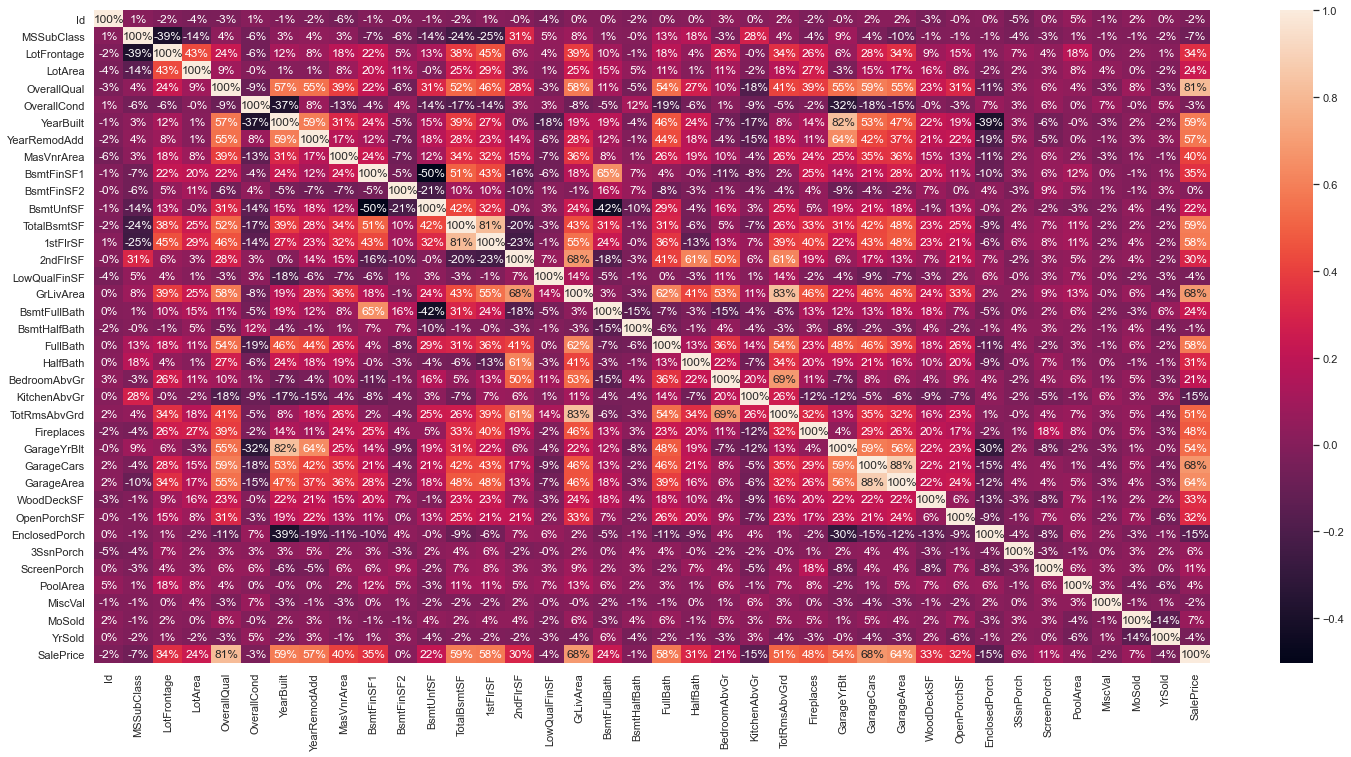

In [18]:
plt.figure(figsize=(25, 12))
corr_mat = train_df.corr()
sns.heatmap(corr_mat, annot=True, fmt='.0%')

Correlation matrix is very useful check any linear relationships.

There are a few features really strongly correlated with SalePrice: 
- The most correlated is OveralQual (actually it is categorical feature with order). 
- GarageCars and GarageArea seem to be good predictors too (they are very strongly correlated with each other).
- GrLivArea looks promising too.
- There are other with more than 50% of type *Build and *SF

Let's analyse features mentioned above and other interesting categorical features.

<AxesSubplot:>

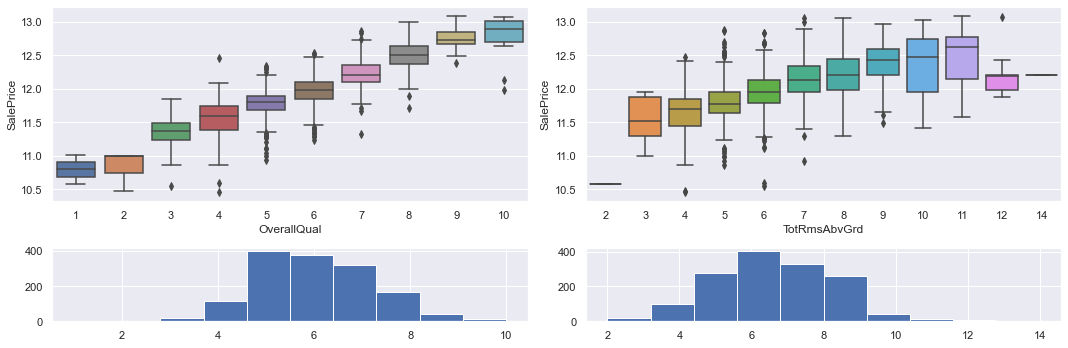

In [55]:
fig = plt.figure(tight_layout=True, figsize=(15, 5))
grid = GridSpec(nrows=6, ncols=2)
ax_up_1 = fig.add_subplot(grid[:4, 0])
ax_up_2 = fig.add_subplot(grid[:4, 1])
ax_low_1 = fig.add_subplot(grid[4:, 0])
ax_low_2 = fig.add_subplot(grid[4:, 1])

sns.boxplot(y='SalePrice', x='OverallQual', data=train_df, ax=ax_up_1)
sns.boxplot(y='SalePrice', x='TotRmsAbvGrd', data=train_df, ax=ax_up_2)
train_df['OverallQual'].hist(ax=ax_low_1)
train_df['TotRmsAbvGrd'].hist(ax=ax_low_2)

**OverallQual** and **TotRmsAbvGrd** looks very good. Generally it is reasonable to assume that higher quality can increase prices. The same is true for number of rooms. In most of cases more rooms is better than less.

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

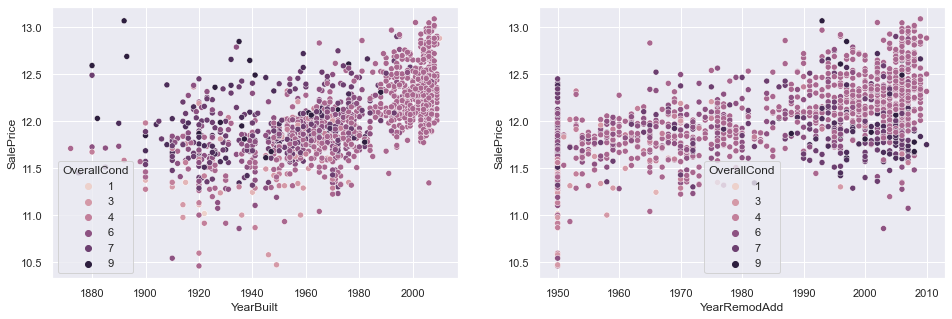

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(x='YearBuilt', y='SalePrice', hue='OverallCond', data=train_df, ax=ax1)
sns.scatterplot(x='YearRemodAdd', y='SalePrice', hue='OverallCond', data=train_df, ax=ax2)

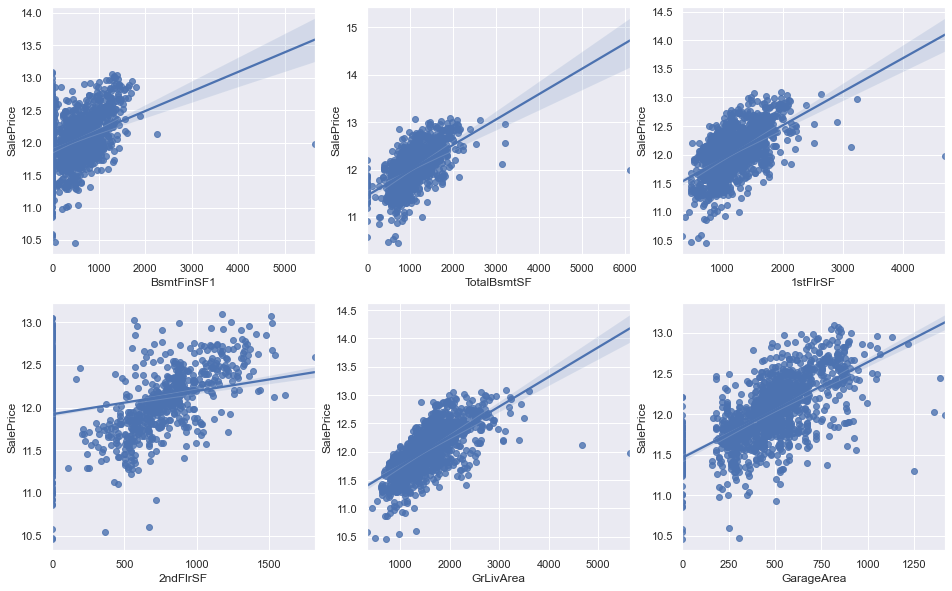

In [105]:
features_to_analyse = ['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 
                       '2ndFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i, ax in enumerate(axes.flat):
    sns.regplot(y='SalePrice', x=features_to_analyse[i], 
                data=train_df[features_to_analyse], ax=ax)

More space means higher price. Sounds pretty obvious. I think it makes sense to sum **TotalBsmtSF**, **1stFlrSF** and **2ndFlrSF**. The results is a total space. Correlation with every feature is large so probably they will be useful in modeling. Let's check the distribution and multicollinearity

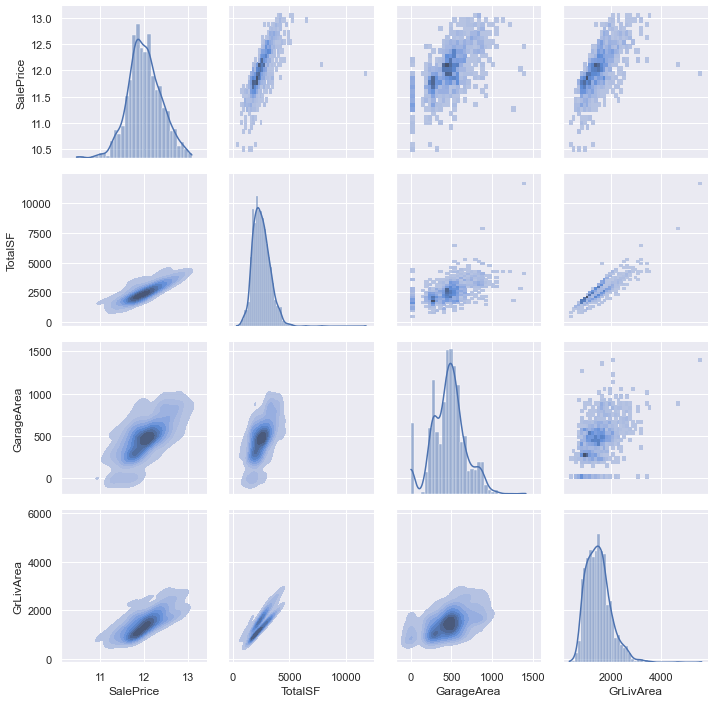

In [113]:
temp = train_df.copy()
temp['TotalSF'] =  temp['TotalBsmtSF'] + temp['1stFlrSF'] + temp['2ndFlrSF']
cols = ['SalePrice', 'TotalSF', 'GarageArea', 'GrLivArea']
g = sns.PairGrid(temp[cols])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

### Machine Learning

In [157]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [12]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'OverallQual', 'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_train[c].values)) 
    all_train[c] = lbl.transform(list(all_train[c].values))

In [13]:
all_train['TotalRooms'] = all_train['TotRmsAbvGrd'] + all_train['FullBath']
all_train['TotalSF'] = all_train['TotalBsmtSF'] + all_train['1stFlrSF'] + all_train['2ndFlrSF']

In [14]:
train_ind = all_train[all_train['Id'].isin(train_df['Id'])].index
test_ind = all_train[all_train['Id'].isin(test_df['Id'])].index

all_train.drop(columns=['Utilities', 'Id', 'SalePrice'], inplace=True)

skew_df = all_train.iloc[train_ind].select_dtypes(exclude='object').apply(lambda x: skew(x))
high_skew_cols = (skew_df[skew_df > 1]).index
all_train[high_skew_cols] = np.log1p(all_train[high_skew_cols])

all_train = pd.get_dummies(all_train)

In [17]:
train = all_train.iloc[train_ind]
X_test = all_train.iloc[test_ind]
labels = train_df['SalePrice']

### XGBoost

In [227]:
xgb_model = XGBRegressor(n_estimators=1000,
                         max_depth=3,
                         eta=0.02,
                         min_child_weight=0.7,
                         colsample_bytree=0.45,
                         random_state=42)
scoring = cross_val_score(xgb_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

0.11830442164534377

In [228]:
xgb_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.45, eta=0.02, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=3,
             min_child_weight=0.7, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [229]:
lgb_model = lgb.LGBMRegressor(objective='regression',
                              num_leaves=6,
                              learning_rate=0.01, 
                              n_estimators=7000,
                              max_bin=200, 
                              bagging_fraction=0.8,
                              bagging_freq=4, 
                              bagging_seed=8,
                              feature_fraction=0.2,
                              feature_fraction_seed=8,
                              random_state=42)
scoring = cross_val_score(lgb_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

0.12144030207043924

In [230]:
gb_model = GradientBoostingRegressor(n_estimators=350, 
                                     max_depth=3, 
                                     learning_rate=0.05,
                                     subsample=0.28,
                                     loss='huber',
                                     alpha=0.95,
                                     random_state=42)
scoring = cross_val_score(gb_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

0.11837830458357428

In [245]:
ridge_model = make_pipeline(RobustScaler(), Ridge(alpha=20))
scoring = cross_val_score(ridge_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

0.12529119739138672

In [243]:
svr_model = make_pipeline(RobustScaler(), SVR(kernel='poly', degree=1, C=1, coef0=7.8))
scoring = cross_val_score(svr_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

0.12601150521683854

In [233]:
base_models = [('xgb', xgb_model),
               ('lgb', lgb_model),
               ('gb', gb_model),
               ('ridge', ridge_model),
               ('svr', svr_model)]
final_model = Ridge(alpha=5)
stacking_model = StackingRegressor(estimators=base_models, 
                                   final_estimator=final_model)
scoring = cross_val_score(stacking_model, train, labels, scoring='neg_mean_squared_error')
np.sqrt(np.mean(-scoring))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


0.11521426243145617

### Final predictions

In [234]:
stacking_model.fit(train, labels)
Y_pred = stacking_model.predict(X_test)

final_pred = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': np.expm1(Y_pred)})
final_pred.to_csv('results.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 